# Utilisation Visualizations

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
# plt.style.use('ggplot')
plt.rcParams.update({"axes.grid": True, "grid.alpha": 0.5})

plt.set_cmap('tab10')

<Figure size 640x480 with 0 Axes>

In [104]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [105]:
PLUGS_PER_CLUSTER = {
    'WEBSTER': 6,
    'BRYANT': 9,
    'HIGH': 8,
    'HAMILTON': 3,
    'CAMBRIDGE': 10,
    'MPL': 4,
    'RINCONADA': 3,
    'TED': 8
}

## Data preprocessing

### Define which cluster and model to use

In [106]:
model = 'TGCN'

### Load predictions by models trained on censoring strategies

In [107]:
def add_censoring_strategy_predictions(df=None, censoring_level=1, censoring_strategy="Static", forecast_lead=1, keep_obs=False, aware=True, cluster=None, covariates=False):
    directory_path = f"../predictions/forecast_{forecast_lead}_{'aware' if aware else 'unaware'}{'_covariates' if covariates else ''}_{model.lower()}_{censoring_strategy.lower()}_{censoring_level}"
    if not os.path.exists(directory_path):
        raise NotADirectoryError(directory_path)
    
    if cluster is None:
        raise ValueError("Cluster cannot be None")

    preds_path = glob(f"{directory_path}/predictions_{model}_{cluster}*.csv")[0] 
    df_preds = pd.read_csv(preds_path, parse_dates=["Date"], index_col=0)

    if 'Date' not in df_preds.columns:
        df_preds = df_preds.reset_index()

    # We have to shift date with forecast lead normalized to 30 minutes
    df_preds.Date = df_preds.Date + pd.DateOffset(minutes=30*(forecast_lead-1))

    # Because we HAD a bug of double predictions being generated
    # df_preds.dropna(inplace=True, how='all')

    # Assume we have forecast horizon of 1. Then we rename the columns to something more readable
    df_preds.rename(columns={
        cluster+"_1": f"Censored Observations {censoring_strategy} {censoring_level}",
        cluster+"_1_pred": f"Predicted {censoring_strategy} {censoring_level}",
        f"{cluster}_1_true": "True Observations"
    }, inplace=True)

    df_preds["No. Plugs per Hub"] = PLUGS_PER_CLUSTER[cluster]
    df_preds["Cluster"] = cluster

    if not keep_obs:
        df_preds = df_preds.drop(["True Observations", "No. Plugs per Hub", "Cluster"], axis=1)

    if df is None:
        return df_preds
    return df.merge(df_preds, on="Date")

### Visualization functions

In [108]:
get_relevant_cols = lambda censoring_level, censoring_strategy: [
        'Date', 'No. Plugs per Hub', "True Observations",
        f"Censored Observations {censoring_strategy} {censoring_level}", f"Predicted {censoring_strategy} {censoring_level}"]

def plot_predictions(df, censoring_level, censoring_strategy):
    # Keep only relevant columns
    df_plot = df.copy()[get_relevant_cols(censoring_level, censoring_strategy)]

    cluster = df.Cluster.unique()[0]
    
    fig, ax = plt.subplots(figsize=(15, 7))
    ax.axhline(y=df_plot[df_plot.Date < '2019-05-30'][f'Censored Observations {censoring_strategy} {censoring_level}'].max(), linestyle='--', label='Censored Threshold', color='black', )
    df_plot[df_plot.Date < '2019-05-30']\
        .drop('No. Plugs per Hub', axis=1)\
        .drop(f"Censored Observations {censoring_strategy} {censoring_level}", axis=1)\
        .plot(x="Date", ax=ax, title=f"{model} Predictions for {cluster} cluster with censoring strategy {censoring_strategy} {censoring_level}", ylabel='Number of sessions', colormap='tab10')

    # Set horizontal line at the maximum number of plugs
    ax.legend()
    fig.savefig(f"../Figures/prediction_timeseries_{model}_{cluster}_{censoring_strategy}_{censoring_level}.png")
    plt.show()

In [109]:
def plot_daily_max_sessions(df, censoring_level, censoring_strategy):
    cluster = df.Cluster.unique()[0]
    df_plot = df.copy()[get_relevant_cols(censoring_level, censoring_strategy)]
    # Plot the highest prediction for each day, together with the highest recorded simultaneous number of sessions in a time interval
    fig, ax = plt.subplots(figsize=(20, 7))
    ax.axhline(y=df_plot[df_plot.Date < '2019-05-30'][f'Censored Observations {censoring_strategy} {censoring_level}'].max(), linestyle='--', label='Censored Threshold', color='black', )
    df_plot\
        .drop('No. Plugs per Hub', axis=1) \
        .drop(f"Censored Observations {censoring_strategy} {censoring_level}", axis=1) \
        .groupby(df_plot["Date"].dt.date).max() \
        .plot(x="Date", ax=ax, title=f"Max number of sessions for each day in cluster {cluster}", colormap='tab10')
    ax.set_title(f"Max number of sessions for each day in cluster {cluster}")
    ax.set_ylabel("Number of sessions")
    plt.show()

In [110]:
def plot_utilisation_per_day(df, censoring_level, censoring_strategy):
    cluster = df.Cluster.unique()[0]
    df_util_plot = df.copy()
    cols = get_relevant_cols(censoring_level, censoring_strategy)
    cols.remove('Date')
    cols.remove('No. Plugs per Hub')
    # We should provide tau from the model training
    for col in cols:
        df_util_plot['tau_'+col] = df_util_plot[col].max()

    sessions_per_day = df_util_plot.groupby(df_util_plot["Date"].dt.date).sum().copy()

    # Calculate utilisation
    for col in cols:
        sessions_per_day['utilisation_'+col] = sessions_per_day[col] / sessions_per_day['No. Plugs per Hub']
    # drop all tau columns
    sessions_per_day = sessions_per_day[sessions_per_day.columns[sessions_per_day.columns.str.startswith('utilisation_')]]
    # remove utilisation_ from the column names
    sessions_per_day.columns = sessions_per_day.columns.str.replace('utilisation_', '')
    fig, ax = plt.subplots(figsize=(15, 5))
    sessions_per_day.plot(ax=ax, colormap='tab10')

    ax.set_title(f"Utilisation per day in cluster {cluster}")
    ax.set_ylabel("Utilisation")
    fig.savefig(f"../Figures/daily_utilisation_{model}_{cluster}_{censoring_strategy}_{censoring_level}.png")

### Utilisation functions

In [111]:
def calculate_utility(df, max_tau, censoring_level, censoring_strategy, mean=True):
    """ 
    Calulcate the utility for a given cluster, given predictions, censored and true values of usage, for taus from 1 - max_tau.
    """
    cols = get_relevant_cols(censoring_level, censoring_strategy)
    cols.remove('Date')
    cols.remove('No. Plugs per Hub')
    util_values = {level: [] for level in cols}
    # calculate the utility for predicted usage, true usage and censored usage, for each tau
    for level, util_list in util_values.items():
        
        for tau_hypothetical in range(1, max_tau + 1):
            df_util = df.copy()
            # clip the values to the hypothetical tau (we use values from df instead of df_util to avoid clipping the values multiple times)
            df_util[level] = df[level].clip(upper=tau_hypothetical)#.round()
            # add the tau_hypothetical as a column
            df_util[f'tau_{tau_hypothetical}'] = tau_hypothetical
            # Sum the half-hourly values to get the daily values
            tmp = df_util.groupby(df_util["Date"].dt.date)[[level, f'tau_{tau_hypothetical}']].sum()
            # calculate the utility per day
            tmp['utilisation'] = (tmp[level] / tmp[f'tau_{tau_hypothetical}'])
            # add the mean utility to the list
            if mean:
                util_list.append(tmp['utilisation'].mean())
            else:
                util_list.append(tmp['utilisation'].std())
            # When when the utilisations is <= 20%
    return util_values

In [112]:
def plot_utility(df, max_tau, censoring_level, censoring_strategy, ax=None, plot_std=False, color='black'):
    demand_goal = 0.20
    utility_values = calculate_utility(df, max_tau, censoring_level, censoring_strategy)
    for i, val in enumerate(utility_values['True Observations']):
        if np.round(val,2) <= demand_goal:
            print(f"True Observations hit {demand_goal*100}% utilisation at tau: {i+1}")
            break
    if plot_std:
        utility_values_std = calculate_utility(df, max_tau, censoring_level, censoring_strategy, mean=False)
        
        for i, val in enumerate(utility_values[f"Predicted {censoring_strategy} {censoring_level}"]):
            if val <= demand_goal:
                print(f"Predicted {censoring_strategy} {censoring_level} hit {demand_goal*100}% utilisation at tau: {i+1}, with std: {utility_values_std[f'Predicted {censoring_strategy} {censoring_level}'][i]}")
                break
        df_utilisation_std = pd.DataFrame(utility_values_std)
        df_utilisation_std['Capacity'] = df_utilisation_std.index + 1
    
    df_utilisation = pd.DataFrame(utility_values)
    df_utilisation['Capacity'] = df_utilisation.index + 1
    capacity = df['No. Plugs per Hub'].max()
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 6), sharey=True)
        # Only plot true observations if nothing else is plotted yet
        # Plot observed demand
        ax.plot(
            df_utilisation[df_utilisation.Capacity <= capacity]['Capacity'],
            df_utilisation[df_utilisation.Capacity <= capacity]["True Observations"],
            linestyle='-', marker='o', label="Ground Truth", color='black'
        )
        ax.plot(
            df_utilisation[df_utilisation.Capacity >= capacity]['Capacity'],
            df_utilisation[df_utilisation.Capacity >= capacity]["True Observations"],
            linestyle='dashed', marker='o', color='black', alpha=0.5
        )
        # fig.suptitle(f"{model} Predicted vs observed utilisation for cluster {cluster} for different capacities")

    # Might change if the censoring level is string
    predicted_col_name = f"Predicted {censoring_strategy} {censoring_level}"
    if isinstance(censoring_level, str):
        censoring_level = int(censoring_level[0])
    max_observed_by_model = 0
    if censoring_strategy == "Dynamic":
        max_observed_by_model = capacity - censoring_level
    else:
        max_observed_by_model = censoring_level

    # Plot predicted demand
    
    ax.plot(
        df_utilisation[df_utilisation.Capacity <= max_observed_by_model]['Capacity'],
        df_utilisation[df_utilisation.Capacity <= max_observed_by_model][predicted_col_name],
        linestyle='-', marker='o', label=f"Predicted demand {censoring_strategy} {censoring_level}",
        color=color
    )
    print(predicted_col_name, color)
    ax.plot(
        df_utilisation[df_utilisation.Capacity >= max_observed_by_model]['Capacity'],
        df_utilisation[df_utilisation.Capacity >= max_observed_by_model][predicted_col_name],
        linestyle='dashed', marker='o', color=color, alpha=0.5
    )
    if plot_std:
        ax.fill_between(
            df_utilisation[df_utilisation.Capacity <= max_observed_by_model]['Capacity'],
            df_utilisation[df_utilisation.Capacity <= max_observed_by_model][predicted_col_name] - df_utilisation_std[df_utilisation_std.Capacity <= max_observed_by_model][predicted_col_name],
            df_utilisation[df_utilisation.Capacity <= max_observed_by_model][predicted_col_name] + df_utilisation_std[df_utilisation_std.Capacity <= max_observed_by_model][predicted_col_name],
            alpha=0.2, 
            color=color
        )
        ax.fill_between(
            df_utilisation[df_utilisation.Capacity >= max_observed_by_model]['Capacity'],
            df_utilisation[df_utilisation.Capacity >= max_observed_by_model][predicted_col_name] - df_utilisation_std[df_utilisation_std.Capacity >= max_observed_by_model][predicted_col_name],
            df_utilisation[df_utilisation.Capacity >= max_observed_by_model][predicted_col_name] + df_utilisation_std[df_utilisation_std.Capacity >= max_observed_by_model][predicted_col_name],
            alpha=0.2, color=color
        )

    ax.set_xlabel("Capacity")
    ax.set_ylabel("Utilization")
    ax.yaxis.set_tick_params(labelleft=True)
    ax.legend()
    return ax

### 30 min forecast lead

Load predictions

In [113]:
# Add the predictions for the different censoring strategies
df = add_censoring_strategy_predictions(None, 2, "Dynamic", keep_obs=True, forecast_lead=1, aware=True, cluster='WEBSTER').reset_index()
df = add_censoring_strategy_predictions(df, 1, "Dynamic",  forecast_lead=1, aware=True, cluster='WEBSTER')
df = add_censoring_strategy_predictions(df, 2, "Static", forecast_lead=1, aware=True, cluster='WEBSTER')
df = add_censoring_strategy_predictions(df, 3, "Static", forecast_lead=1, aware=True, cluster='WEBSTER')

df.head()

,index,Date,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations,No. Plugs per Hub,Cluster,Censored Observations Dynamic 1,Predicted Dynamic 1,Censored Observations Static 2,Predicted Static 2,Censored Observations Static 3,Predicted Static 3
0,0,2019-04-08 00:30:00,0.0,0.010163,0.0,6,WEBSTER,0.0,0.010797,0.0,0.008033,0.0,0.008155
1,1,2019-04-08 01:00:00,0.0,0.007160,0.0,6,WEBSTER,0.0,0.008166,0.0,0.006631,0.0,0.007503
2,2,2019-04-08 01:30:00,0.0,0.006033,0.0,6,WEBSTER,0.0,0.007380,0.0,0.006112,0.0,0.008016
3,3,2019-04-08 02:00:00,0.0,0.005922,0.0,6,WEBSTER,0.0,0.007478,0.0,0.006731,0.0,0.009222
4,4,2019-04-08 02:30:00,0.0,0.007513,0.0,6,WEBSTER,0.0,0.009424,0.0,0.008920,0.0,0.012661


Once an EV-charging station is built, all costs are essentially fixed, so utilization is key to achieving efficiency. Still, even a quite low utilization is likely to result in lines at busy times. In practice, the stand-alone, fast-charger industry uses a 20% utilization as a rule of thumb. But if a charging station is utilized at more than this 20% threshold, the operator will likely look to expand capacity or, more likely, add another site nearby.

### 24 hours forecast lead

Load predictions

In [114]:
df_48 = add_censoring_strategy_predictions(None, 2, "Dynamic", keep_obs=True, forecast_lead=48, aware=True, cluster='WEBSTER')
df_48 = add_censoring_strategy_predictions(df_48, 1, "Dynamic", forecast_lead=48, aware=True, cluster='WEBSTER')
df_48 = add_censoring_strategy_predictions(df_48, 2, "Static", forecast_lead=48, aware=True, cluster='WEBSTER')
df_48 = add_censoring_strategy_predictions(df_48, 3, "Static", forecast_lead=48, aware=True, cluster='WEBSTER')

df_48.head()

,Date,Censored Observations Dynamic 2,Predicted Dynamic 2,True Observations,No. Plugs per Hub,Cluster,Censored Observations Dynamic 1,Predicted Dynamic 1,Censored Observations Static 2,Predicted Static 2,Censored Observations Static 3,Predicted Static 3
0,2019-04-09 00:00:00,0.0,0.163704,0.0,6,WEBSTER,0.0,0.182593,0.0,0.267409,0.0,0.147992
1,2019-04-09 00:30:00,0.0,0.144775,0.0,6,WEBSTER,0.0,0.154781,0.0,0.197241,0.0,0.116295
2,2019-04-09 01:00:00,0.0,0.132710,0.0,6,WEBSTER,0.0,0.134664,0.0,0.148841,0.0,0.095516
3,2019-04-09 01:30:00,0.0,0.131791,0.0,6,WEBSTER,0.0,0.126434,0.0,0.121588,0.0,0.086214
4,2019-04-09 02:00:00,0.0,0.135818,0.0,6,WEBSTER,0.0,0.124603,0.0,0.105997,0.0,0.083048


Utilisation plot

True Observations hit 20.0% utilisation at tau: 10
Predicted Dynamic 2 black
True Observations hit 20.0% utilisation at tau: 10
Predicted Dynamic 1 black
True Observations hit 20.0% utilisation at tau: 10
Predicted Static 2 black
True Observations hit 20.0% utilisation at tau: 10
Predicted Static 3 black


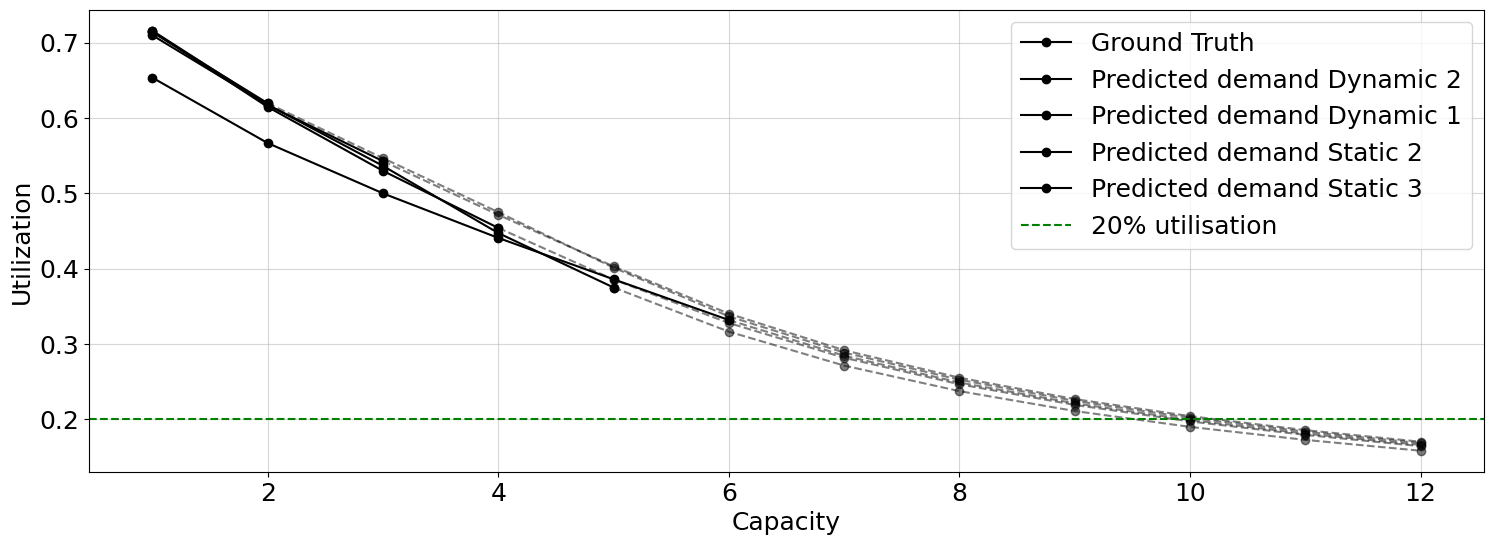

In [115]:
ax = plot_utility(df_48.reset_index(), 12, 2, "Dynamic")
ax = plot_utility(df_48.reset_index(), 12, 1, "Dynamic", ax=ax)
ax = plot_utility(df_48.reset_index(), 12, 2, "Static", ax=ax)
ax = plot_utility(df_48.reset_index(), 12, 3, "Static", ax=ax)


ax.axhline(y=0.2, linestyle='--', color='g', label="20% utilisation")
plt.legend()
plt.show()

### 24 hours forecast lead plotted together with unaware model

In [167]:
CLUSTER = 'HIGH' # Cluster for which we want to plot the predictions aware vs unaware

In [168]:
df_48_aware = add_censoring_strategy_predictions(None, 2, "Static", forecast_lead=48, aware=True, cluster=CLUSTER, keep_obs=True)
df_48_unaware = add_censoring_strategy_predictions(None, 2, "Static", forecast_lead=48, aware=False, cluster=CLUSTER, keep_obs=True)
# As we're not using a censored dataset
df_48_unaware["True Observations"] = df_48_unaware["Censored Observations Static 2"]
df_48_unaware["No. Plugs per Hub"] = PLUGS_PER_CLUSTER[CLUSTER]

# df_48_unaware.head()

********** Aware **********
True Observations hit 20.0% utilisation at tau: 11
Predicted Static 2 hit 20.0% utilisation at tau: 11, with std: 0.04791104940585583
Predicted Static 2 #E24A33
********** Unaware **********
True Observations hit 20.0% utilisation at tau: 6
Predicted Static 2 hit 20.0% utilisation at tau: 5, with std: 0.026658568167321216
Predicted Static 2 #348ABD


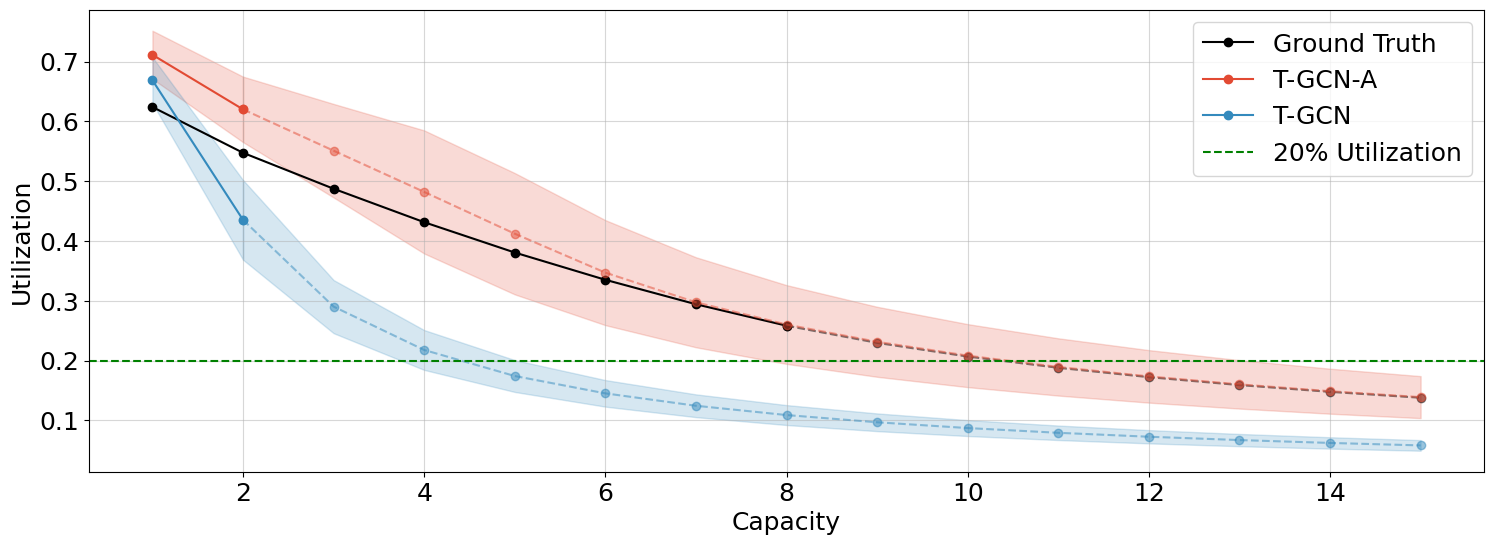

In [169]:
# Plot aware
print("*"*10 + " Aware " + "*"*10)
ax = plot_utility(df_48_aware.reset_index(), 15, 2, "Static", plot_std=True, color="#E24A33")
ax.lines[-2].set_label("T-GCN-A")
# Plot unaware
print("*"*10 + " Unaware " + "*"*10)
ax = plot_utility(df_48_unaware.reset_index(), 15, 2, "Static", ax=ax, plot_std=True, color="#348ABD")
# Change label of the last plot
ax.lines[-2].set_label("T-GCN")
ax.axhline(y=0.2, linestyle='--', color='g', label="20% Utilization")
plt.legend()
plt.savefig(f"../Figures/aware_vs_unaware_{CLUSTER}.png", bbox_inches='tight', dpi=300)
plt.show()

Time series plot

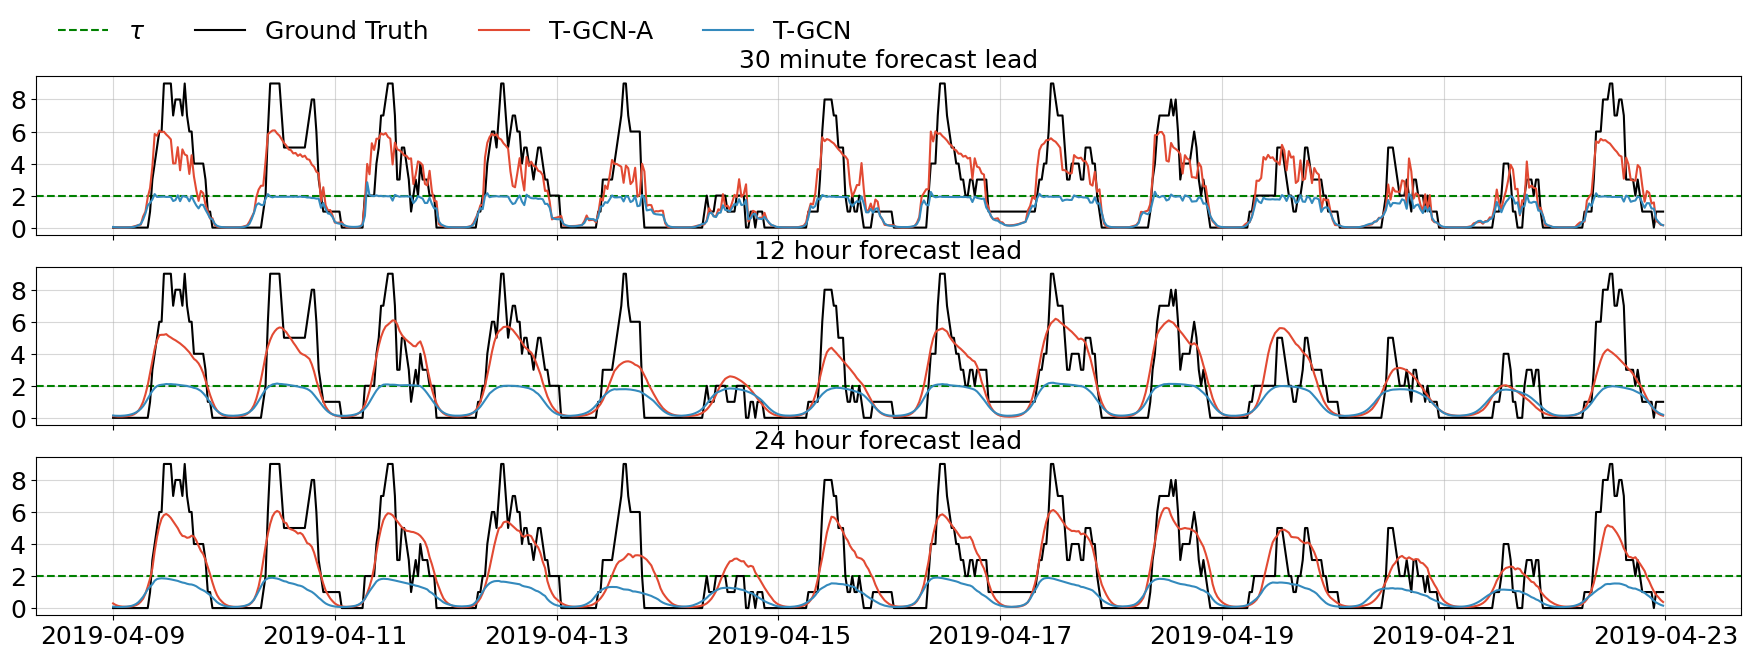

In [119]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_forecast(ax, forecast_lead, title, strategy='Static', censor_level=2, cluster='WEBSTER', max_date='2019-04-29', start_date='2019-04-09'):
    df_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster=cluster)
    df_aware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster=cluster, keep_obs=True)

    df_unaware_plot = df_unaware.copy().reset_index()
    df_unaware_plot = df_unaware_plot[(df_unaware_plot.Date >= start_date) & (df_unaware_plot.Date < max_date)]

    df_aware_plot = df_aware.copy().reset_index()
    df_aware_plot = df_aware_plot[(df_aware_plot.Date >= start_date) & (df_aware_plot.Date < max_date)]

    # Plot y=3
    if strategy == 'Static':
        y = censor_level
    else:
        y = np.maximum(2, PLUGS_PER_CLUSTER[cluster] - censor_level)
    ax.axhline(y=y, linestyle='--', color='g', label=r"$\tau$")

    ax.plot(df_aware_plot.Date, df_aware_plot["True Observations"], color='black', label="Ground Truth", alpha=1)
    ax.plot(df_aware_plot.Date, df_aware_plot[f"Predicted {strategy} {censor_level}"], color='#E24A33', label="T-GCN-A")
    # Plot unaware
    ax.plot(df_unaware_plot.Date, df_unaware_plot[f"Predicted {strategy} {censor_level}"], color='#348ABD', label="T-GCN")

    # plot a red dot if its the weekend
    # df_aware_weekend = df_aware_plot[df_aware_plot.Date.dt.dayofweek > 4]
    #ax.scatter(df_aware_weekend.Date, df_aware_weekend[f"Predicted {strategy} {censor_level}"], color='red', marker='o', s=25)

fig, ax = plt.subplots(3, figsize=(22, 7), sharex=True, sharey=True)

# set title

# define colormap
cmap = plt.get_cmap("tab20")

start_date = '2019-04-09'
max_date = '2019-04-23' # 2 weeks
CLUSTER = 'BRYANT'
STRAT = 'Static'
CENSOR_LEVEL = 2

#fig.suptitle(f"Predictions for {CLUSTER} cluster {STRAT} {CENSOR_LEVEL}")

forecast_leads = [1, 24, 48]
titles = [ "30 minute forecast lead", "12 hour forecast lead", "24 hour forecast lead"]

for i in range(3):
    ax[i].set_title(titles[i])
    plot_forecast(ax[i], forecast_leads[i], titles[i], cluster=CLUSTER, strategy=STRAT, censor_level=CENSOR_LEVEL, max_date=max_date, start_date=start_date)
    # plot a dot if its the weekend

ax[0].legend()
# Make y.axis integer
ax[0].yaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))
# place legend on top to the left
ax[0].legend(loc='upper left', bbox_to_anchor=(0, 1.5), ncol=4, fancybox=False, shadow=False, frameon=False)

# save fig 
plt.savefig(f"../Figures/aware_vs_unaware_forecast_leads_{CLUSTER}_1_24_48.png", bbox_inches='tight', dpi=300)
plt.show()


In [120]:
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
cluster_names = [
    "BRYANT",
    "CAMBRIDGE",
    "HAMILTON",
    "HIGH",
    "MPL",
    "RINCONADA",
    "TED",
    "WEBSTER",
]
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


for cluster in cluster_names:
    df_aware_experiment = add_censoring_strategy_predictions(None, 2, "Dynamic", forecast_lead=48, aware=True, cluster=cluster, keep_obs=True)
    mape = smape(df_aware_experiment["True Observations"], df_aware_experiment["Predicted Dynamic 2"].astype(int))
    print(f"MAPE for {cluster} cluster: {mape}")



MAPE for BRYANT cluster: 52.075297387797384
MAPE for CAMBRIDGE cluster: 73.20641453453952
MAPE for HAMILTON cluster: 53.88125157470395
MAPE for HIGH cluster: 50.31287330394473
MAPE for MPL cluster: 65.72751322751323
MAPE for RINCONADA cluster: 79.06911375661375
MAPE for TED cluster: 62.54772564296374
MAPE for WEBSTER cluster: 52.00275143727525


## Single cluster

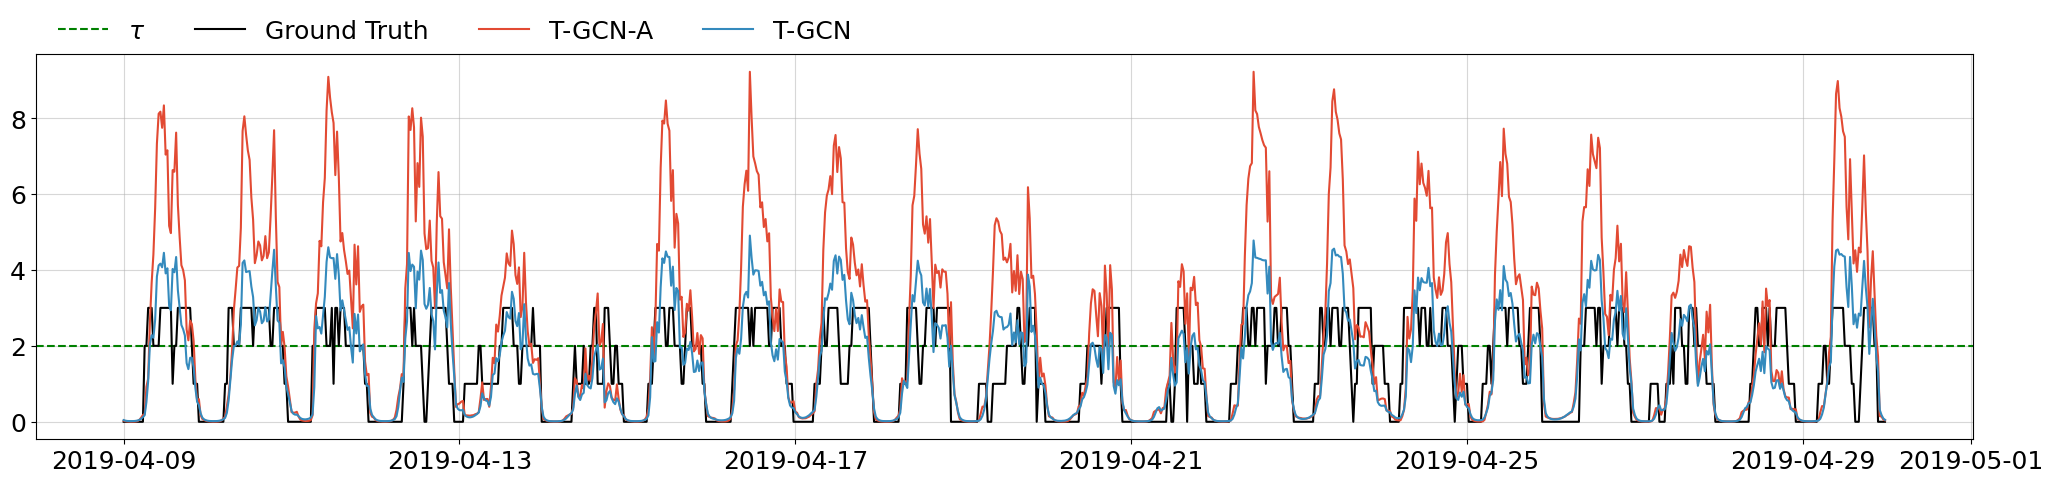

In [121]:
fig, ax = plt.subplots(1, figsize=(25, 5), sharex=True, sharey=True)
max_date = '2019-04-30' # 2 weeks

plot_forecast(ax, 1, "", cluster='HAMILTON', strategy='Dynamic', censor_level=2, max_date=max_date, start_date=start_date)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncol=4, fancybox=False, shadow=False, frameon=False)
fig.savefig(f"../Figures/hamilton_going_ham.png", bbox_inches='tight', dpi=300)


## Aggregation of macro-clusters

In [160]:
forecast_lead = 48
strategy = 'Static'
censor_level = 2

df_webster = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster='WEBSTER', keep_obs=True)
df_bryant = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster='BRYANT', keep_obs=True)
df_hamilton = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster='HAMILTON', keep_obs=True)
df_high = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster='HIGH', keep_obs=True)
df_cambridge = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster='CAMBRIDGE', keep_obs=True)
df_mpl = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster='MPL', keep_obs=True)
df_rinconada = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster='RINCONADA', keep_obs=True)
df_ted = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=True, cluster='TED', keep_obs=True)

# unaware models 
df_webster_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster='WEBSTER', keep_obs=True)
df_bryant_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster='BRYANT', keep_obs=True)
df_hamilton_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster='HAMILTON', keep_obs=True)
df_high_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster='HIGH', keep_obs=True)
df_cambridge_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster='CAMBRIDGE', keep_obs=True)
df_mpl_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster='MPL', keep_obs=True)
df_rinconada_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster='RINCONADA', keep_obs=True)
df_ted_unaware = add_censoring_strategy_predictions(None, censor_level, strategy, forecast_lead=forecast_lead, aware=False, cluster='TED', keep_obs=True)

df_total_webster_bryant_hamilton_high = pd.concat([df_webster, df_bryant, df_hamilton, df_high]).groupby('Date').sum().reset_index()
df_total_unaware_webster_bryant_hamilton_high = pd.concat([df_webster_unaware, df_bryant_unaware, df_hamilton_unaware, df_high_unaware]).groupby('Date').sum().reset_index()

Plot Webster, Bryant, Hamilton and High

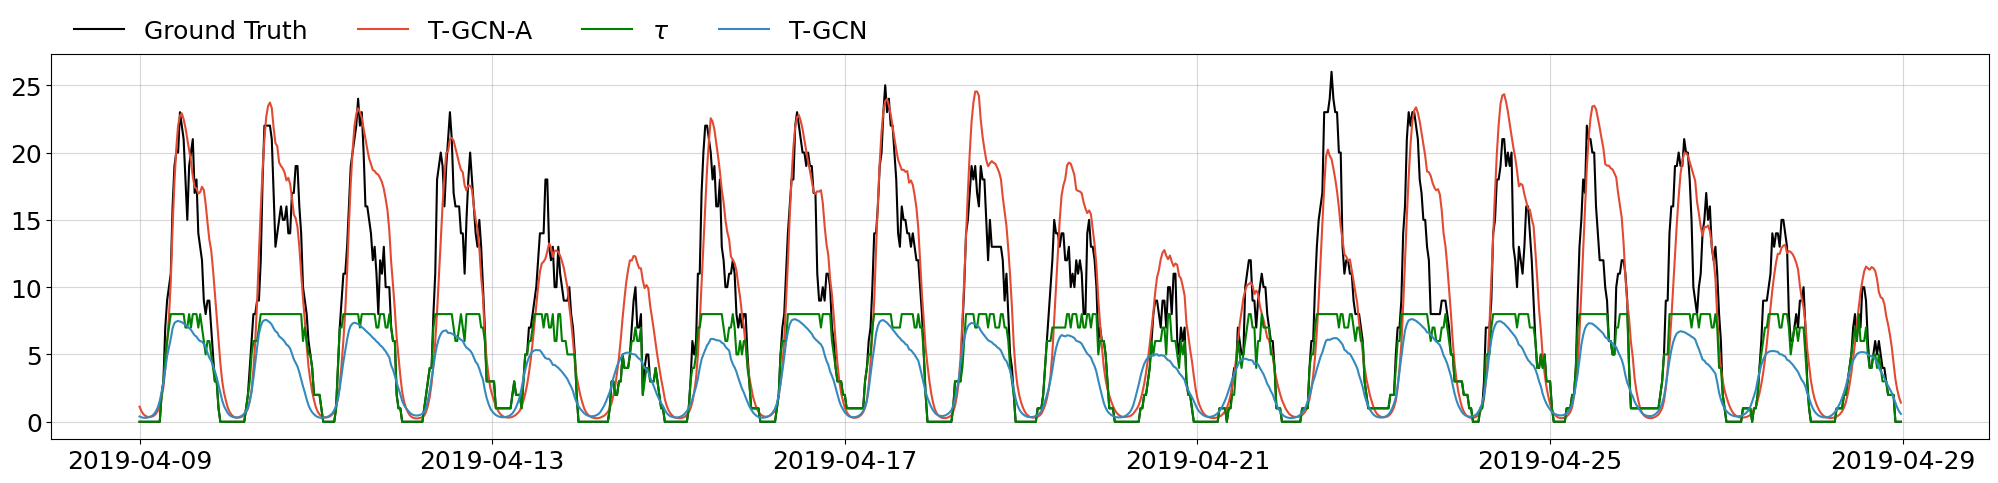

In [165]:

fig, ax = plt.subplots(figsize=(25, 5))

df_total_webster_bryant_hamilton_high = df_total_webster_bryant_hamilton_high[df_total_webster_bryant_hamilton_high.Date < '2019-04-29']
df_total_unaware_webster_bryant_hamilton_high = df_total_unaware_webster_bryant_hamilton_high[df_total_unaware_webster_bryant_hamilton_high.Date < '2019-04-29']

ax.plot(df_total_webster_bryant_hamilton_high.Date, df_total_webster_bryant_hamilton_high["True Observations"], color='black', label="Ground Truth")
ax.plot(df_total_webster_bryant_hamilton_high.Date, df_total_webster_bryant_hamilton_high[f"Predicted {strategy} {censor_level}"], color='#E24A33', label="T-GCN-A")
ax.plot(df_total_webster_bryant_hamilton_high.Date, df_total_webster_bryant_hamilton_high[f"Censored Observations {strategy} {censor_level}"], color='g', label=r"$\tau$")

ax.plot(df_total_unaware_webster_bryant_hamilton_high.Date, df_total_unaware_webster_bryant_hamilton_high[f"Predicted {strategy} {censor_level}"], color='#348ABD', label="T-GCN")
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncol=4, fancybox=False, shadow=False, frameon=False)

fig.savefig(f"../Figures/total_webster_bryant_hamilton_high.png", bbox_inches='tight', dpi=300)
plt.show()

Plot Ted and Cambridge

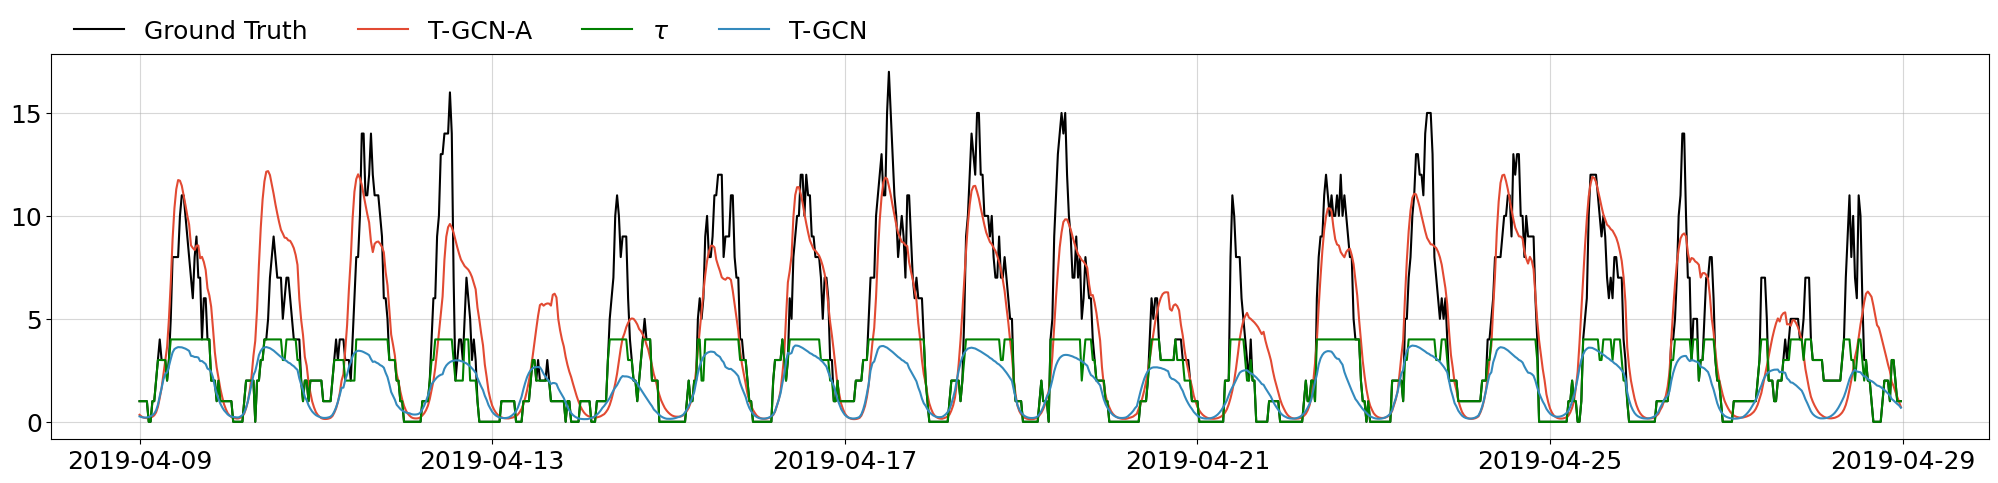

In [166]:
df_total_ted_cambridge = pd.concat([df_ted, df_cambridge]).groupby('Date').sum().reset_index()
df_total_unaware_ted_cambridge = pd.concat([df_ted_unaware, df_cambridge_unaware]).groupby('Date').sum().reset_index()

fig, ax = plt.subplots(figsize=(25, 5))

df_total_ted_cambridge = df_total_ted_cambridge[df_total_ted_cambridge.Date < '2019-04-29']
df_total_unaware_ted_cambridge = df_total_unaware_ted_cambridge[df_total_unaware_ted_cambridge.Date < '2019-04-29']

ax.plot(df_total_ted_cambridge.Date, df_total_ted_cambridge["True Observations"], color='black', label="Ground Truth")
ax.plot(df_total_ted_cambridge.Date, df_total_ted_cambridge[f"Predicted {strategy} {censor_level}"], color='#E24A33', label="T-GCN-A")
ax.plot(df_total_ted_cambridge.Date, df_total_ted_cambridge[f"Censored Observations {strategy} {censor_level}"], color='g', label=r"$\tau$")
ax.plot(df_total_unaware_ted_cambridge.Date, df_total_unaware_ted_cambridge[f"Predicted {strategy} {censor_level}"], color='#348ABD', label="T-GCN")
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.15), ncol=4, fancybox=False, shadow=False, frameon=False)
fig.savefig(f"../Figures/total_ted_cambridge.png", bbox_inches='tight', dpi=300)
plt.show()


In [124]:
df_total_ted_cambridge

,Date,Censored Observations Static 2,Predicted Static 2,True Observations,No. Plugs per Hub
0,2019-04-09 00:00:00,1.0,0.337554,1.0,18
1,2019-04-09 00:30:00,1.0,0.260366,1.0,18
2,2019-04-09 01:00:00,1.0,0.209896,1.0,18
3,2019-04-09 01:30:00,1.0,0.185508,1.0,18
4,2019-04-09 02:00:00,1.0,0.176223,1.0,18
...,...,...,...,...,...
955,2019-04-28 21:30:00,3.0,1.737890,3.0,18
956,2019-04-28 22:00:00,2.0,1.458560,2.0,18
957,2019-04-28 22:30:00,1.0,1.215424,1.0,18
958,2019-04-28 23:00:00,1.0,0.974811,1.0,18


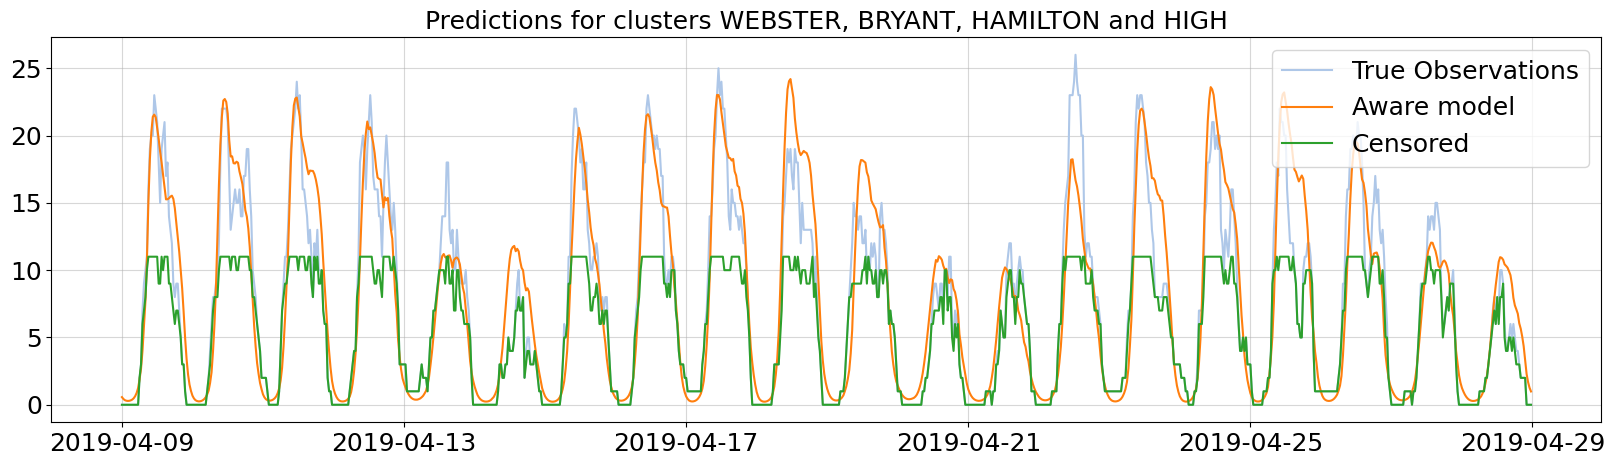

In [125]:
df_webster = add_censoring_strategy_predictions(None, 3, 'Static', forecast_lead=forecast_lead, aware=True, cluster='WEBSTER', keep_obs=True)
df_bryant = add_censoring_strategy_predictions(None, 3, 'Static', forecast_lead=forecast_lead, aware=True, cluster='BRYANT', keep_obs=True)
df_hamilton = add_censoring_strategy_predictions(None, 3, 'Static', forecast_lead=forecast_lead, aware=True, cluster='HAMILTON', keep_obs=True)
df_high = add_censoring_strategy_predictions(None, 3, 'Static', forecast_lead=forecast_lead, aware=True, cluster='HIGH', keep_obs=True)

df_total = pd.concat([df_webster, df_bryant, df_hamilton, df_high]).groupby('Date').sum().reset_index()

fig, ax = plt.subplots(figsize=(20, 5))

df_total = df_total[df_total.Date < '2019-04-29']
# ax.axhline(y=26 - 4*2, linestyle='--', color=cmap(0), label=f"Censor threshold")
ax.set_title("Predictions for clusters WEBSTER, BRYANT, HAMILTON and HIGH")

ax.plot(df_total.Date, df_total["True Observations"], color=cmap(1), label="True Observations")
ax.plot(df_total.Date, df_total[f"Predicted Static 3"], color=cmap(2), label="Aware model")
ax.plot(df_total.Date, df_total[f"Censored Observations Static 3"], color=cmap(4), label="Censored")
ax.legend()
plt.show()

## 24 hour vs 30 min forecast
For Dynamic 2 

In [126]:
CLUSTER = 'CAMBRIDGE'

In [127]:
df_24_vs_30 = add_censoring_strategy_predictions(None, 2, "Dynamic", keep_obs=True, forecast_lead=1, aware=True, cluster=CLUSTER)

df_24_vs_30 = df_24_vs_30.add_suffix('_forecast_1')
df_24_vs_30 = df_24_vs_30.rename(columns={'True Observations_forecast_1': 'True Observations'})
df_24_vs_30 = add_censoring_strategy_predictions(df_24_vs_30, 2, "Dynamic", forecast_lead=48, aware=True, cluster=CLUSTER)
df_24_vs_30["No. Plugs per Hub"] = PLUGS_PER_CLUSTER[CLUSTER]

df_24_vs_30.head()

KeyError: 'Date'

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
max_date = '2019-04-29' # 2 weeks
df_24_vs_30_plot = df_24_vs_30.copy().reset_index()
df_24_vs_30_plot = df_24_vs_30_plot[df_24_vs_30_plot.Date < max_date]


plt.plot(
    df_24_vs_30_plot.Date, np.minimum(3, df_24_vs_30_plot["No. Plugs per Hub"] - 2), # Dynamic 2
    linestyle='--', label="Censor threshold") 
plt.plot(df_24_vs_30_plot.Date, df_24_vs_30_plot["True Observations"], label="True Observations")
plt.plot(df_24_vs_30_plot.Date, df_24_vs_30_plot["Predicted Dynamic 2_forecast_1"], label="30 min forecast")
plt.plot(df_24_vs_30_plot.Date, df_24_vs_30_plot["Predicted Dynamic 2"], label="24 hour forecast forecast")

# Set horizontal line at the maximum number of plugs
ax.set_title(f"24 hour vs 30 min forecast lead predictions for {CLUSTER} cluster Dynamic 2")
ax.legend()
plt.show()

In [ ]:
ax = plot_utility(df_48.reset_index(), 12, 2, "Static", plot_std=True)

In [ ]:
from scipy.stats import poisson, norm
import matplotlib.pyplot as plt
import numpy as np

#creating an array of values between
#0 to 20 with a difference of 1
x = np.arange(0, 5, 1)
y = -poisson.logpmf(2, x, 0)
   
plt.plot(x, y, 'bo') 
plt.show()

In [ ]:
x = np.arange(0, 5, 1)
y = -norm.logpdf(x, loc=2, scale=2)
   
plt.plot(x, y, 'bo') 
plt.show()